In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import ccf

In [3]:
date_block_mapping = {
    0: dt.datetime(2013, 1, 1), 1: dt.datetime(2013, 2, 1), 2: dt.datetime(2013, 3, 1), 3: dt.datetime(2013, 4, 1),
    4: dt.datetime(2013, 5, 1), 5: dt.datetime(2013, 6, 1), 6: dt.datetime(2013, 7, 1), 7: dt.datetime(2013, 8, 1),
    8: dt.datetime(2013, 9, 1), 9: dt.datetime(2013, 10, 1), 10: dt.datetime(2013, 11, 1), 11: dt.datetime(2013, 12, 1),
    12: dt.datetime(2014, 1, 1), 13: dt.datetime(2014, 2, 1), 14: dt.datetime(2014, 3, 1), 15: dt.datetime(2014, 4, 1),
    16: dt.datetime(2014, 5, 1), 17: dt.datetime(2014, 6, 1), 18: dt.datetime(2014, 7, 1), 19: dt.datetime(2014, 8, 1),
    20: dt.datetime(2014, 9, 1), 21: dt.datetime(2014, 10, 1), 22: dt.datetime(2014, 11, 1), 23: dt.datetime(2014, 12, 1),
    24: dt.datetime(2015, 1, 1), 25: dt.datetime(2015, 2, 1), 26: dt.datetime(2015, 3, 1), 27: dt.datetime(2015, 4, 1),
    28: dt.datetime(2015, 5, 1), 29: dt.datetime(2015, 6, 1), 30: dt.datetime(2015, 7, 1), 31: dt.datetime(2015, 8, 1),
    32: dt.datetime(2015, 9, 1), 33: dt.datetime(2015, 10, 1)
}

# Plan


# 1. Exploratory data analysis and visualization:

###       - First understand general characteristics eg what is the general trend?

        average all datasets together

        What is the average number of sales per month?

        Is there typical purchasing behaviours/a measurable pattern?
            Is there an autocorrelation above 0.5 at any point? Focus on these months where there is a linear pattern?
            Is there cross-correlation across years? Cycle?
            Can I find non-linear patterns?


###    - understand general demand for each shop

        Do certain shops have more typical purchasing behaviours? Is there a measurable pattern?
        Is there a way to group shops by trend? eg are some shops visited more during christmas and others are visited more during the weekends
        How much do shops vary around mean (standard deviation, coefficient of variation)?
        Is there a cross-correlation between any shops?
        which shops are customers more likely to go to during high demand seasons or days
        What shops perform above and below the average (outliers)?
        How to remove outliers or split shops up by popularity/number of sales? z score or interquartile range?

###    - Understand demand of each item

        Follow similar steps

        Which items are worth further exploration?

# 2. Model fitting and predictions


###     - Data cleaning/prep

        What moving average parameters am I using?

        What groups have I created?

        Am I adding additional features eg season?
                Month/Season/Event 
                Number of sales in the previous year?
                Number of sales/average in the previous week, two weeks or month?
                popularity of shop/group?
                Number of popular items in shop?

        Outliers removed?

        Data imputation - where there is a measurable pattern I will add in values for missing data


###    Starting with simple model then complex - most likely not enough data for deep learning/AI

        - Regression: ARIMA/autoregression
        
                Independent Variables:
                        Month/Season/Event 
                        Number of sales in the previous year?
                        Number of sales/average in the previous week, two weeks or month?
                        popularity of shop/group?
                        Number of popular items in shop?

                Dependent Variable:
                        Number of sales next day/week


        - Bayesian 


        - Machine Learning
            Can K-means clustering be used to determine whether there is a pattern and what the variables are?
            SVM & XGBOOST

    
    


## Conclusions 


       Average number of sales decreasing yearly
       
       - What timeframe was the dataset collected?
        2 years 10 months - Jan 2013 - Oct 2015

        Data is negatively skewed - more shops have sales within the lower end from 0 to ~3000



# 1. Exploratory data analysis and visualization:

###       - First understand general characteristics eg what is the general trend?

        average all datasets together


In [5]:
sales = pd.read_csv('data/sales_train.csv')
sales = sales[(sales['item_cnt_day'] > 0 ) & (sales['item_price'] > 0)] # remove rows where there was no sale or item does not have price
sales['date'] = pd.to_datetime(sales['date'], dayfirst=True)
sales = sales.sort_values(by=['shop_id', 'date'], ascending=[True, True])
sales['year'] = sales['date'].dt.year
sales['month'] = sales['date'].dt.month
sales['day'] = sales['date'].dt.day

sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day
37618,2013-01-03,0,0,10928,110.0,1.0,2013,1,3
37636,2013-01-03,0,0,11041,221.0,3.0,2013,1,3
37673,2013-01-03,0,0,11388,716.0,1.0,2013,1,3
37683,2013-01-03,0,0,11160,137.0,1.0,2013,1,3
37703,2013-01-03,0,0,8070,137.0,1.0,2013,1,3


In [6]:
# Group by 'date' and 'shop_id' to sum 'item_cnt_day' for each shop per day
grouped = sales.groupby(['date', 'day', 'month','year', 'shop_id'])['item_cnt_day'].sum().reset_index()

# Calculate the average number of sales per day
average_sales_per_day = grouped.groupby(['date','day','month','year'])['item_cnt_day'].mean().reset_index()

grouped = sales.groupby(['year', 'month', 'shop_id'])['item_cnt_day'].sum().reset_index()
# Group by 'year' and 'month' again to get the mean of item_cnt_day per unique shop_id
average_sales_per_month = grouped.groupby(['year', 'month']).agg({'item_cnt_day': 'mean'}).reset_index()


print(average_sales_per_day.head(), '\n', average_sales_per_month.head())


        date  day  month  year  item_cnt_day
0 2013-01-01    1      1  2013    115.117647
1 2013-01-02    2      1  2013    200.780488
2 2013-01-03    3      1  2013    165.422222
3 2013-01-04    4      1  2013    150.636364
4 2013-01-05    5      1  2013    144.545455 
    year  month  item_cnt_day
0  2013      1   2930.000000
1  2013      2   2790.913043
2  2013      3   3205.173913
3  2013      4   2387.533333
4  2013      5   2381.044444


In [7]:
# change year to same for all to aid visualisation
average_sales_per_day['date'] = pd.to_datetime(average_sales_per_day['date'].dt.strftime('2010-%m-%d'), format='%Y-%m-%d')
average_sales_per_day


,date,day,month,year,item_cnt_day
0,2010-01-01,1,1,2013,115.117647
1,2010-01-02,2,1,2013,200.780488
2,2010-01-03,3,1,2013,165.422222
3,2010-01-04,4,1,2013,150.636364
4,2010-01-05,5,1,2013,144.545455
...,...,...,...,...,...
1029,2010-10-27,27,10,2015,37.023810
1030,2010-10-28,28,10,2015,85.690476
1031,2010-10-29,29,10,2015,37.880952
1032,2010-10-30,30,10,2015,54.214286


## Original dataset noisy as expected

Trade-off between granularity and reduction of noise?

Will apply moving average with different parameters and evaluate predictive models/machine learning by calculating MSE between them

In [99]:

fig = px.line(average_sales_per_day, x='date', y='item_cnt_day', color='year',title='Average of Items Purchased per Day')
fig.update_layout(xaxis_title='Date (ignore year)', yaxis_title='Items Sold')
fig.show()

In [100]:

fig = px.line(average_sales_per_month, x='month', y='item_cnt_day', color='year', title='Average of Items Purchased per Month')
fig.update_layout(xaxis_title='Date', yaxis_title='Items Sold')
fig.show()

 Is there typical purchasing behaviours/a measurable pattern?
            Is there an autocorrelation above 0.5 at any point? Focus on these months where there is a linear pattern?
            Is there cross-correlation across years? Cycle?
            Can I find non-linear patterns?

In [9]:
average_sales_per_day

,date,day,month,year,item_cnt_day
0,2010-01-01,1,1,2013,115.117647
1,2010-01-02,2,1,2013,200.780488
2,2010-01-03,3,1,2013,165.422222
3,2010-01-04,4,1,2013,150.636364
4,2010-01-05,5,1,2013,144.545455
...,...,...,...,...,...
1029,2010-10-27,27,10,2015,37.023810
1030,2010-10-28,28,10,2015,85.690476
1031,2010-10-29,29,10,2015,37.880952
1032,2010-10-30,30,10,2015,54.214286


# Autocorrelation results

Autocorelation calculated on data before sliding average applied

Expected seasonality for retail data

Less data collected in 2015 explains difference in correlation, likely not enough data 
to reveal pattern though pattern is still slightly comparable to 2013.

There is a moderate positive autocorrelation at lag of 7, which peaks in 7 day intervals, though this decreases in significance over time

Suggests that if sales on one day were higher than average, sales will be increased at a similar rate 7 days later and vice versa

This may also be true for 14 and 21 days later, but with a weaker similarity in distance from average

There may also be a moderate positive correlation at lag of 1 meaning if sales increased yesterday they may similarly increase the next day. However this correlation may be a result of the autocorrelation method.

### Two new features:

Difference from average sales 7 days prior (standard deviation)

Actual number of sales 7 days prior

Could also incorporate difference the day before, 14 and 21 days to see how this affects accuracy



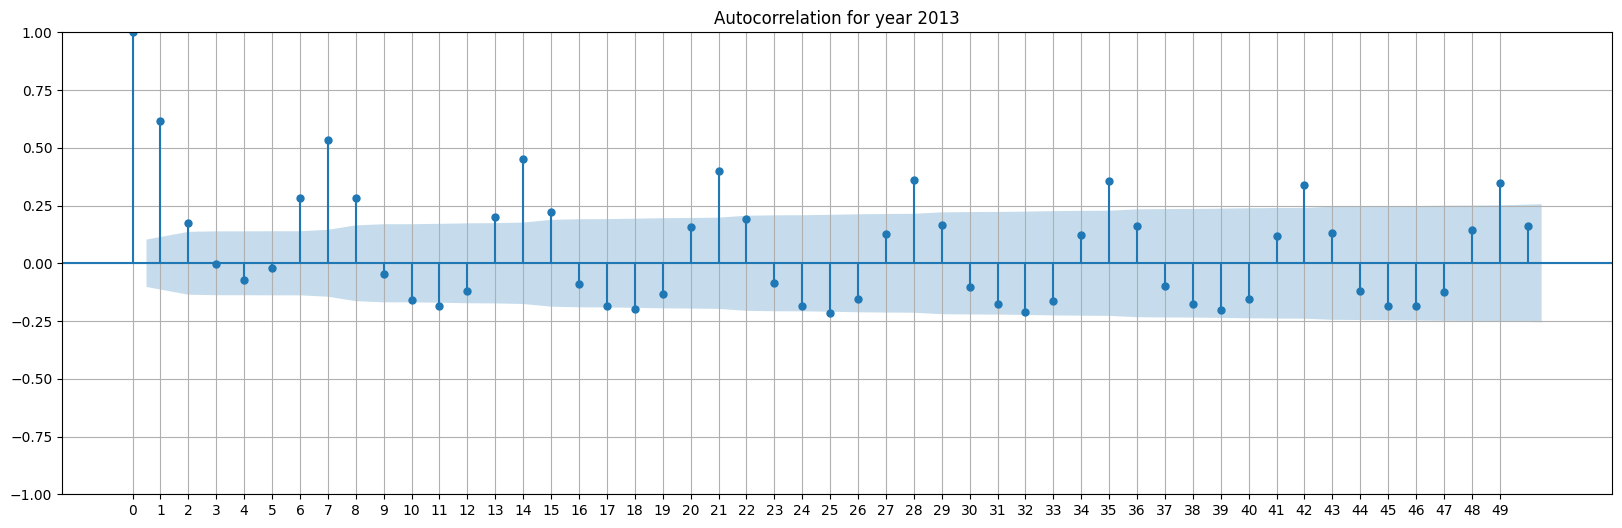

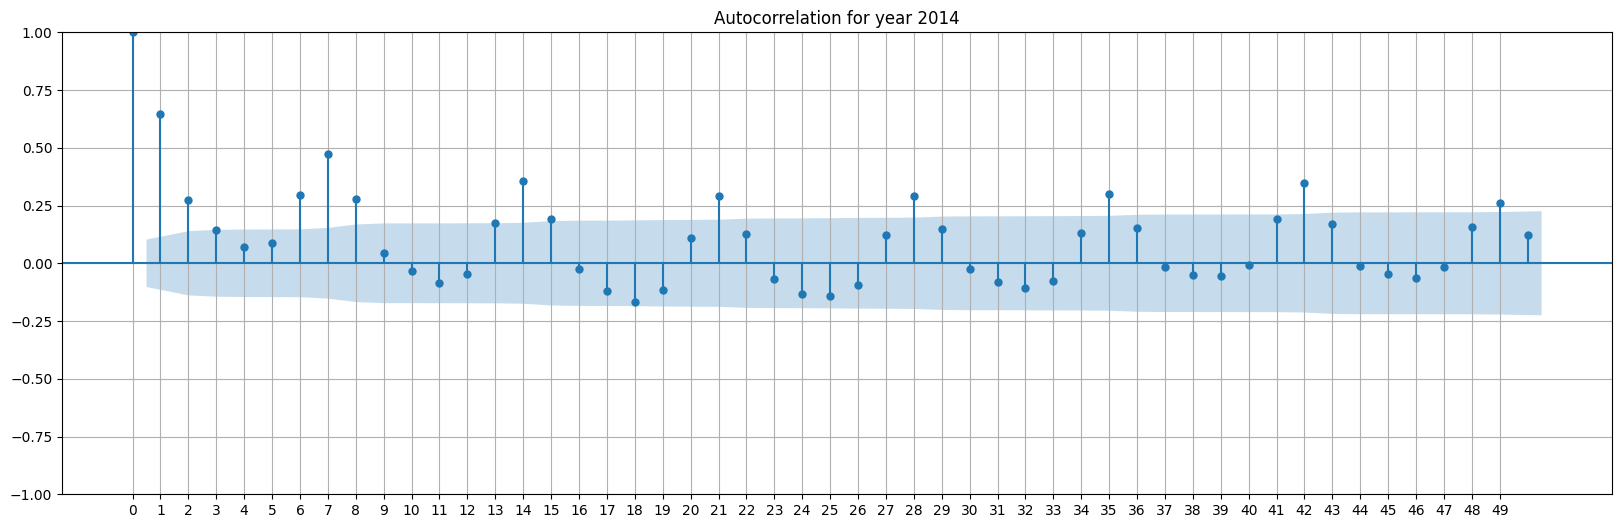

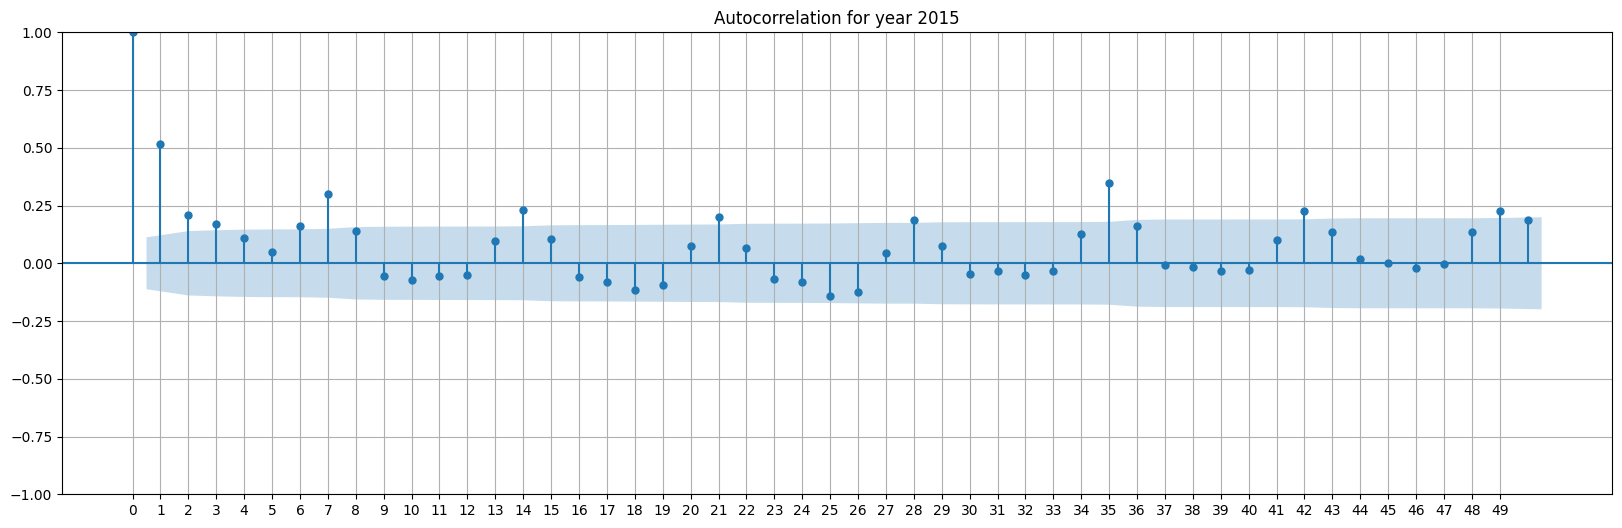

In [147]:

def plot_shop_autocorrelation(year, data):
    shop_data = data[data['year'] == year]
    shop_data = shop_data['item_cnt_day'].dropna()
    # Plot autocorrelation
    fig, ax = plt.subplots(figsize=(20, 6))  # Adjust figsize as needed
    plot_acf(shop_data, ax=ax, title=f'Autocorrelation for year {year}', lags=50)
    
    # Customize x-axis ticks
    ax.set_xticks(range(0, 50, 1))  # Set ticks every 1 unit
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: int(x)))  # Format x-axis labels as integers
    
    # Add grid lines
    ax.grid(True)
    
    plt.show()

# Assuming `average_sales_per_day` is your DataFrame containing the sales data
years = average_sales_per_day['year'].unique()

# Plot autocorrelation for each year
for year in years:
    plot_shop_autocorrelation(year, average_sales_per_day)  

In [151]:
min(len(ts_2013), len(ts_2014))

TypeError: 'int' object is not iterable

In [153]:
ts_2015

730     117.888889
731     157.978723
732     136.160000
733     130.760000
734     115.460000
           ...    
1029     37.023810
1030     85.690476
1031     37.880952
1032     54.214286
1033     75.780488
Name: item_cnt_day, Length: 304, dtype: float64

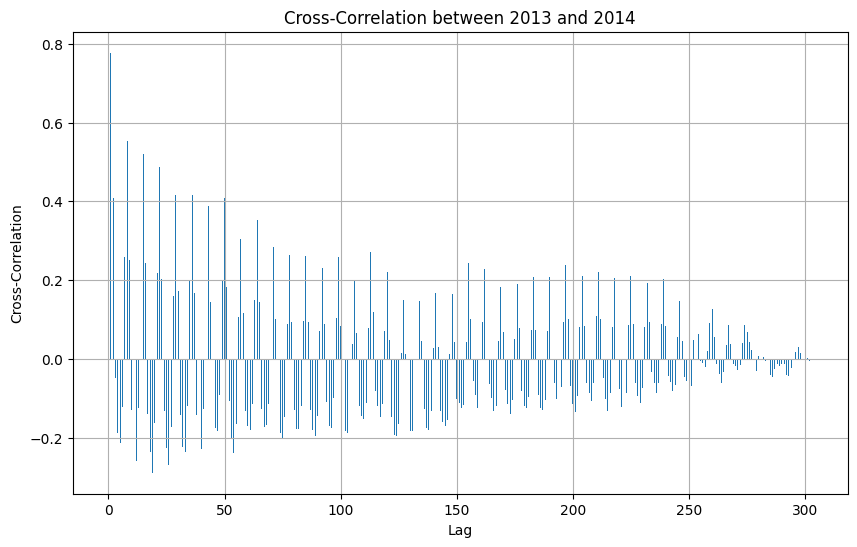

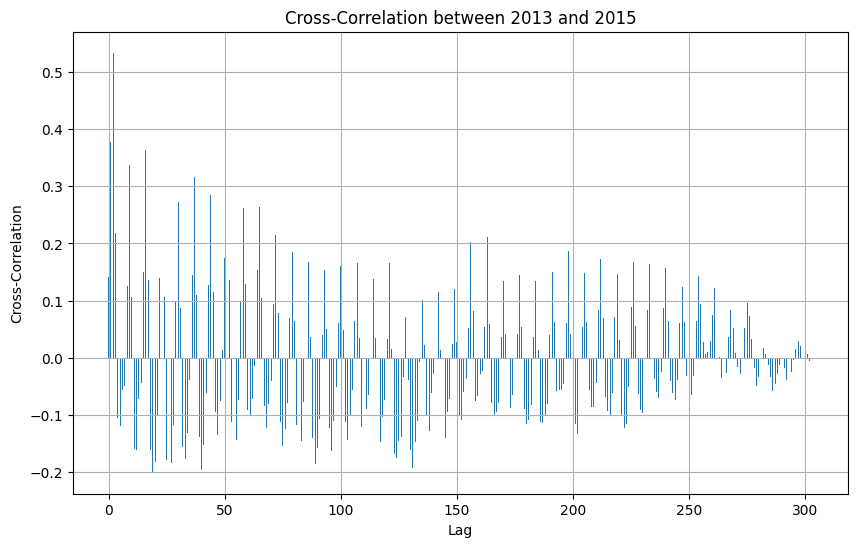

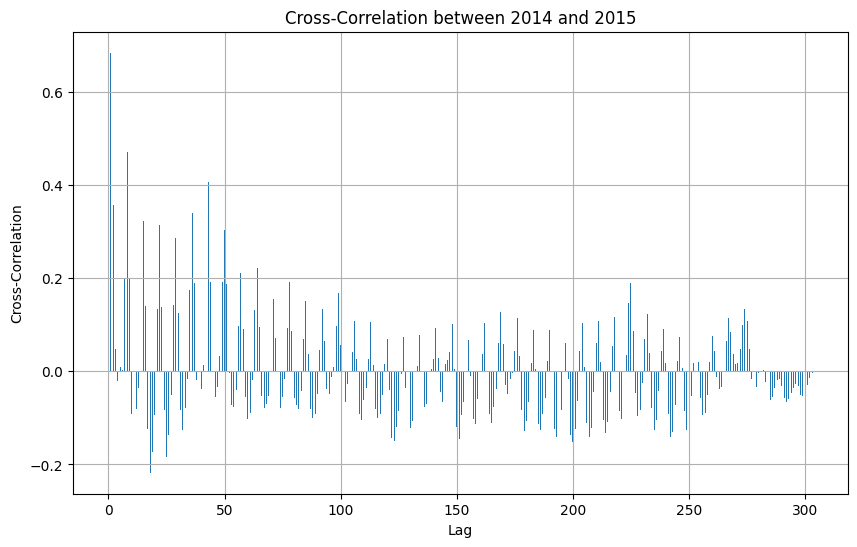

In [144]:
# Extract time series for each year
ts_2013 = average_sales_per_day[average_sales_per_day['year'] == 2013]['item_cnt_day']
ts_2014 = average_sales_per_day[average_sales_per_day['year'] == 2014]['item_cnt_day']
ts_2015 = average_sales_per_day[average_sales_per_day['year'] == 2015]['item_cnt_day']

# Align the time series by trimming to the same length if necessary
min_length = min(len(ts_2013), len(ts_2014), len(ts_2015))
ts_2013 = ts_2013[:min_length]
ts_2014 = ts_2014[:min_length]
ts_2015 = ts_2015[:min_length]

# Compute cross-correlation
def plot_cross_correlation(ts1, ts2, title):
    correlation = ccf(ts1, ts2, adjusted=False)
    lags = np.arange(len(correlation))
    
    plt.figure(figsize=(10, 6))
    plt.bar(lags, correlation, width=0.4)
    plt.title(title)
    plt.xlabel('Lag')
    plt.ylabel('Cross-Correlation')
    plt.grid(True)
    plt.show()

# Plot cross-correlation for each pair of years
plot_cross_correlation(ts_2013, ts_2014, 'Cross-Correlation between 2013 and 2014')
plot_cross_correlation(ts_2013, ts_2015, 'Cross-Correlation between 2013 and 2015')
plot_cross_correlation(ts_2014, ts_2015, 'Cross-Correlation between 2014 and 2015')

Average number of sales decreasing yearly

## Preprocessing step
## Simple moving average applied with windows of 7, 14 and 30 days

Visual inspection shows 7 day window may be smoothest/less noise with underlying pattern intact

In [115]:
average_sales_per_day['SMA_7'] = average_sales_per_day['item_cnt_day'].rolling(window=7, min_periods=1).mean()
average_sales_per_day['SMA_14'] = average_sales_per_day['item_cnt_day'].rolling(window=14, min_periods=1).mean()
average_sales_per_day['SMA_30'] = average_sales_per_day['item_cnt_day'].rolling(window=30, min_periods=1).mean()

average_sales_per_day

,date,day,month,year,item_cnt_day,day_month,SMA_14,SMA_30,SMA_7
0,2010-01-01,1,1,2013,115.117647,1-1,115.117647,115.117647,115.117647
1,2010-01-02,2,1,2013,200.780488,2-1,157.949067,157.949067,157.949067
2,2010-01-03,3,1,2013,165.422222,3-1,160.440119,160.440119,160.440119
3,2010-01-04,4,1,2013,150.636364,4-1,157.989180,157.989180,157.989180
4,2010-01-05,5,1,2013,144.545455,5-1,155.300435,155.300435,155.300435
...,...,...,...,...,...,...,...,...,...
1029,2010-10-27,27,10,2015,37.023810,27-10,50.437324,57.432711,50.428061
1030,2010-10-28,28,10,2015,85.690476,28-10,52.551103,58.481124,57.053912
1031,2010-10-29,29,10,2015,37.880952,29-10,51.924133,56.319432,56.900850
1032,2010-10-30,30,10,2015,54.214286,30-10,52.054422,54.815193,54.768197


In [118]:
# Create subplots
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=('SMA with Window Size 7','SMA with Window Size 14', 'SMA with Window Size 30'))

# Define color map for years
color_map = {2013: 'blue', 2014: 'red', 2015: 'green'}  # Define colors for specific years

# Add traces for SMA with window size 7
for year in average_sales_per_day['year'].unique():
    if year in color_map:
        shop_data = average_sales_per_day[average_sales_per_day['year'] == year]
        fig.add_trace(go.Scatter(x=shop_data['date'], y=shop_data['SMA_7'], mode='lines', 
                                 name=f'{year} ', line=dict(color=color_map[year])), 
                      row=1, col=1)

# Add traces for SMA with window size 14
for year in average_sales_per_day['year'].unique():
    if year in color_map:
        shop_data = average_sales_per_day[average_sales_per_day['year'] == year]
        fig.add_trace(go.Scatter(x=shop_data['date'], y=shop_data['SMA_14'], mode='lines', 
                                 name=f'{year} ', line=dict(color=color_map[year])), 
                      row=2, col=1)

# Add traces for SMA with window size 30
for year in average_sales_per_day['year'].unique():
    if year in color_map:
        shop_data = average_sales_per_day[average_sales_per_day['year'] == year]
        fig.add_trace(go.Scatter(x=shop_data['date'], y=shop_data['SMA_30'], mode='lines', 
                                 name=f'{year}', line=dict(color=color_map[year])), 
                      row=3, col=1)

# Update layout
fig.update_layout(height=600, width=1000, title_text="Simple Moving Average of Items Purchased per Day by Year")

# Customizing legend to show only specific years
legend_items = []
for year in color_map:
    legend_items.append(dict(label=f'{year}', method='update', args=[{'visible': [True, True, False, False]}, {'title': f'{year}'}]))

fig.update_layout(
    updatemenus=[
        {
            'buttons': legend_items,
            'direction': 'down',
            'showactive': True,
        }
    ]
)

fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='SMA of Items Sold')

# Show plot
fig.show()

In [59]:
monthly_sales = sales.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index()
monthly_sales['date'] = monthly_sales['date_block_num'].map(date_block_mapping)
monthly_sales.head()

,shop_id,date_block_num,item_cnt_day,date
0,0,0,5578.0,2013-01-01
1,0,1,6127.0,2013-02-01
2,1,0,2947.0,2013-01-01
3,1,1,3364.0,2013-02-01
4,2,0,1146.0,2013-01-01


In [97]:
monthly_sales

,shop_id,date_block_num,item_cnt_day,date,month_year,month,z_score
0,0,0,5578.0,2013-01-01,2013-01,2013-01,1.249475
1,0,1,6127.0,2013-02-01,2013-02,2013-02,1.628894
2,1,0,2947.0,2013-01-01,2013-01,2013-01,0.011875
3,1,1,3364.0,2013-02-01,2013-02,2013-02,0.282380
4,2,0,1146.0,2013-01-01,2013-01,2013-01,-0.835301
...,...,...,...,...,...,...,...
1581,59,29,913.0,2015-06-01,2015-06,2015-06,-0.475503
1582,59,30,992.0,2015-07-01,2015-07,2015-07,-0.430520
1583,59,31,1214.0,2015-08-01,2015-08,2015-08,-0.332193
1584,59,32,914.0,2015-09-01,2015-09,2015-09,-0.486059


    - What timeframe was the dataset collected?

Jan 2013 - Oct 2015

In [101]:
print(sales['date'].max(),sales['date'].min())

2015-10-31 00:00:00 2013-01-01 00:00:00


    
    - What is the average number of sales per month? What shops perform above and below this average (outliers)?
    
    - Data is negatively skewed - more shops have sales within the lower end from 0 to ~3000

    - Coefficient of variation - how much do shops vary in number of sales per month? Is this significant?
        
    - How to remove outliers or split shops up by popularity/number of sales? z score or interquartile range?
    - What is the mean, median and std per month?
    - Is there actually a measurable pattern in the data/time series?
    - What does this say about the data?

Average number of sales: 1500-4000 (Highest December 2013 3985 sales, lowest July 2015 1469 sales)

However, coefficient of variation (0.7-0.9) shows there is relatively high variability in sales between shops  

### First step should be to find boundaries for grouping shops based on average monthly sales or other patterns


In [113]:

grouped = monthly_sales.groupby(monthly_sales['date'].dt.to_period('M'))['item_cnt_day'].agg(['mean', 'median', 'std'])
grouped.columns = ['mean', 'median', 'std']

months = grouped.index.to_series().dt.month.astype(str) + '-' + grouped.index.to_series().dt.year.astype(str)
grouped.index = months
grouped.index = pd.to_datetime(grouped.index)

grouped.head()


/var/folders/96/ntd6ngxn5klgfg7ylpwj8n_h0000gn/T/ipykernel_1957/3108999779.py:6: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



,mean,median,std
date,,,
2013-01-01,2921.755556,2127.0,2125.887602
2013-02-01,2784.565217,2210.5,2051.965764
2013-03-01,3198.739130,2536.0,2407.951600
2013-04-01,2330.217391,1863.0,1895.456016
2013-05-01,2377.111111,1931.0,1806.277038


In [112]:
print(grouped.loc[grouped['mean'].idxmax()],"\n",grouped.loc[grouped['mean'].idxmin()])

mean      3985.695652
median    3120.500000
std       3094.483772
Name: 2013-12-01 00:00:00, dtype: float64 
 mean      1469.465116
median    1114.000000
std       1109.043396
Name: 2015-07-01 00:00:00, dtype: float64


In [115]:
cv = grouped['std'] / grouped['mean']
print(cv.loc[cv.idxmax()],"\n",cv.loc[cv.idxmin()])

0.9473247943120834 
 0.6874869930251142


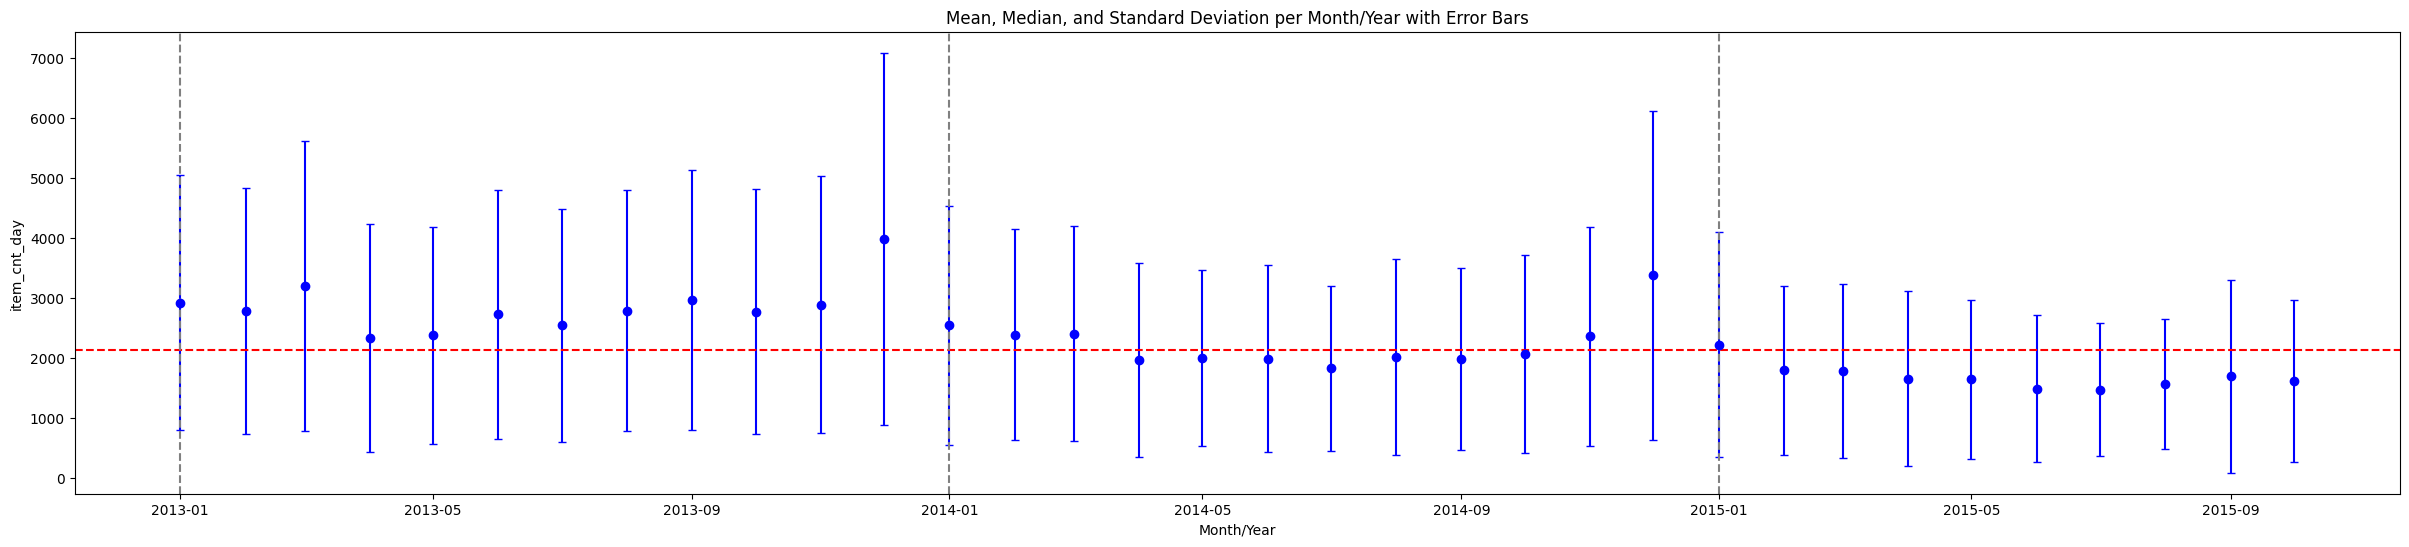

In [87]:

fig, ax = plt.subplots(figsize=(30,6))
ax.errorbar(grouped.index, grouped['mean'], yerr=grouped['std'], fmt='o', capsize=3, color='b')
ax.axhline(grouped['median'].iloc[0], color='r', linestyle='--', label='Median')
ax.set_xlabel('Month/Year')
ax.set_ylabel('item_cnt_day')
ax.set_title('Mean, Median, and Standard Deviation per Month/Year with Error Bars')

for year in grouped.index.to_series().dt.year.unique():
    ax.axvline(x=grouped.index[grouped.index.to_series().dt.year == year].min(), color='grey', linestyle='--')

plt.show()

In [91]:
z_scores = monthly_sales.groupby(monthly_sales['date'].dt.to_period('M'))['item_cnt_day'].apply(lambda x: (x - x.mean()) / x.std())

# Reset the index of the z_scores series to be the same as the index of the monthly_sales dataframe
z_scores = z_scores.reset_index(level=0, drop=True)

# Create a new column 'z_score' in the monthly_sales dataframe
monthly_sales['z_score'] = z_scores

# Define a threshold for outliers (e.g., 2 standard deviations)
threshold = 2.5

# Find shop_id's that are outliers for each month
outliers = monthly_sales[(monthly_sales['z_score'] > threshold) | (monthly_sales['z_score'] < -threshold)]

# Group outliers by month and shop_id
outliers_grouped = outliers.groupby([outliers['date'].dt.to_period('M'), 'shop_id'])['item_cnt_day'].count()

print(outliers_grouped)

date     shop_id
2013-01  31         1
         54         1
2013-02  25         1
         31         1
         54         1
                   ..
2015-09  25         1
         31         1
         55         1
2015-10  25         1
         31         1
Name: item_cnt_day, Length: 68, dtype: int64


In [230]:
outliers_grouped

date     shop_id
2013-01  31         1
         54         1
2013-02  25         1
         31         1
         54         1
                   ..
2015-09  25         1
         31         1
         55         1
2015-10  25         1
         31         1
Name: item_cnt_day, Length: 68, dtype: int64

In [95]:
outliers_dates = outliers_grouped.index.get_level_values(0).to_timestamp()
outliers_shops = outliers_grouped.index.get_level_values(1)

filtered_sales = monthly_sales[~(monthly_sales['date'].isin(outliers_dates) & monthly_sales['shop_id'].isin(outliers_shops))]

In [96]:
filtered_sales

,shop_id,date_block_num,item_cnt_day,date,month_year,month,z_score
0,0,0,5578.0,2013-01-01,2013-01,2013-01,1.249475
1,0,1,6127.0,2013-02-01,2013-02,2013-02,1.628894
2,1,0,2947.0,2013-01-01,2013-01,2013-01,0.011875
3,1,1,3364.0,2013-02-01,2013-02,2013-02,0.282380
4,2,0,1146.0,2013-01-01,2013-01,2013-01,-0.835301
...,...,...,...,...,...,...,...
1581,59,29,913.0,2015-06-01,2015-06,2015-06,-0.475503
1582,59,30,992.0,2015-07-01,2015-07,2015-07,-0.430520
1583,59,31,1214.0,2015-08-01,2015-08,2015-08,-0.332193
1584,59,32,914.0,2015-09-01,2015-09,2015-09,-0.486059


In [100]:
# Filter shops that have a full time series for 2013
full_year_2013 = monthly_sales[(monthly_sales['date_block_num'] >= 0) & (monthly_sales['date_block_num'] <= 11)]
shops_2013 = full_year_2013['shop_id'].unique()

# Filter shops that have a full time series for 2014
full_year_2014 = monthly_sales[(monthly_sales['date_block_num'] >= 12) & (monthly_sales['date_block_num'] <= 23)]
shops_2014 = shops_2013.intersection(full_year_2014['shop_id'].unique())

# Filter shops that have a full time series for 2015
full_year_2015 = monthly_sales[(monthly_sales['date_block_num'] >= 24) & (monthly_sales['date_block_num'] <= 33)]
shops_2015 = shops_2014.intersection(full_year_2015['shop_id'].unique())

# Filter the monthly_sales dataframe to remove shops that don't have a full time series for a year
filtered_sales = monthly_sales[monthly_sales['shop_id'].isin(shops_2015)]

AttributeError: 'numpy.ndarray' object has no attribute 'intersection'

In [125]:
# Calculate Q1, Q3, and IQR for each shop
q1 = monthly_sales.groupby('month_year')['item_cnt_day'].quantile(0.25)
q3 = monthly_sales.groupby('month_year')['item_cnt_day'].quantile(0.75)
iqr = q3 - q1

# Calculate boundaries for each shop
lower_boundary = q1 - 1.5 * iqr
upper_boundary = q3 + 1.5 * iqr

# Create a DataFrame for the boundaries
boundaries = pd.DataFrame({'Q1': q1, 'Q3': q3, 'IQR': iqr, 'Lower Boundary': lower_boundary, 'Upper Boundary': upper_boundary})
boundaries.head()


In [228]:

# Create an empty dataframe to store the shop_ids that meet the condition
upper_df = pd.DataFrame()

# Iterate over each month_year in upper_boundary
for month_year, upper_boundary_value in upper_boundary.items():

    month_year = pd.to_datetime(month_year, format="%Y-%m")
    # Filter monthly_sales for the current month_year
    current_month_sales = monthly_sales[monthly_sales['date'] == month_year]
    
    # Compare item_cnt_day to the upper boundary value
    shop_ids_to_add = current_month_sales[current_month_sales['item_cnt_day'] > upper_boundary_value][['shop_id','month_year','item_cnt_day']]
    
    # Add the shop_ids to the result dataframe
    upper_df = pd.concat([upper_df, shop_ids_to_add], ignore_index=True)

upper_df.head()


,shop_id,month_year,item_cnt_day
0,0,2013-01,5578.0
1,25,2013-01,8215.0
2,27,2013-01,5548.0
3,28,2013-01,7057.0
4,31,2013-01,10173.0


In [229]:
upper_df

,shop_id,month_year,item_cnt_day
0,0,2013-01,5578.0
1,25,2013-01,8215.0
2,27,2013-01,5548.0
3,28,2013-01,7057.0
4,31,2013-01,10173.0
...,...,...,...
211,55,2015-09,6867.0
212,12,2015-10,4181.0
213,25,2015-10,6247.0
214,31,2015-10,6112.0


In [168]:
upper_boundary

month_year
2013-01    4956.500
2013-02    4407.125
2013-03    4870.000
2013-04    3901.125
2013-05    3801.500
2013-06    4877.625
2013-07    5277.375
2013-08    4684.000
2013-09    4970.000
2013-10    4751.500
2013-11    4513.000
2013-12    6783.125
2014-01    4503.625
2014-02    3739.750
2014-03    3891.625
2014-04    3107.500
2014-05    3083.500
2014-06    3149.500
2014-07    2805.500
2014-08    3217.000
2014-09    3367.250
2014-10    3484.625
2014-11    4150.000
2014-12    6295.750
2015-01    3950.000
2015-02    3197.500
2015-03    3122.500
2015-04    2905.750
2015-05    2614.375
2015-06    2694.000
2015-07    2721.500
2015-08    2685.500
2015-09    2580.250
2015-10    3207.500
Freq: M, Name: item_cnt_day, dtype: float64

In [170]:
monthly_sales[monthly_sales['item_cnt_day'].gt(upper_boundary.reindex(monthly_sales.index))]

,shop_id,date_block_num,item_cnt_day,date,month_year,month,z_score


In [172]:
monthly_sales

,shop_id,date_block_num,item_cnt_day,date,month_year,month,z_score
0,0,0,5578.0,2013-01-01,2013-01,2013-01,1.249475
1,0,1,6127.0,2013-02-01,2013-02,2013-02,1.628894
2,1,0,2947.0,2013-01-01,2013-01,2013-01,0.011875
3,1,1,3364.0,2013-02-01,2013-02,2013-02,0.282380
4,2,0,1146.0,2013-01-01,2013-01,2013-01,-0.835301
...,...,...,...,...,...,...,...
1581,59,29,913.0,2015-06-01,2015-06,2015-06,-0.475503
1582,59,30,992.0,2015-07-01,2015-07,2015-07,-0.430520
1583,59,31,1214.0,2015-08-01,2015-08,2015-08,-0.332193
1584,59,32,914.0,2015-09-01,2015-09,2015-09,-0.486059


In [60]:
fig = px.line(monthly_sales, x='date_block_num', y='item_cnt_day', color='shop_id', title='Monthly Sales by Shop')
fig.update_layout(xaxis_title='Month', yaxis_title='Number of Items Sold')
fig.show()

    - Are certain shops more popular than others?

Shop 31 most popular

Top 10 = 31, 25, 54, 28, 27, 42, 6, 18, 50, 19

In [45]:
selected_shops = [31, 25, 54, 28, 27, 42, 6, 18, 50, 19]
filtered_monthly_sales = monthly_sales[monthly_sales['shop_id'].isin(selected_shops)]

# Create the line plot
fig = px.line(filtered_monthly_sales, x='date_block_num', y='item_cnt_day', color='shop_id', title='Monthly Sales by Shop - Top 10')
fig.update_layout(xaxis_title='Month', yaxis_title='Number of Items Sold')
fig.show()

    - Do certain shops have more typical purchasing behaviours?

In [51]:
shop_data = {}
for shop_id, shop_df in monthly_sales.groupby('shop_id'):
    shop_df['month'] = shop_df['date_block_num'] % 12 + 1
    shop_df['year'] = shop_df['date_block_num'] // 12 + 2013
    shop_data[shop_id] = shop_df

# Create a separate plot for each shop
for shop_id, shop_df in shop_data.items():
    if shop_id in [31, 25, 54, 28, 27, 42, 6, 18, 50, 19]:
        fig = px.line(shop_df, x='month', y='item_cnt_day', color='year', title=f'Shop {shop_id} Sales by Month')
        fig.update_layout(xaxis_title='Month', yaxis_title='Number of Items Sold')
        fig.show()